In [33]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from functools import reduce
import datetime
import requests_cache
from plotnine import ggplot, geom_point, aes, geom_boxplot, geom_rect, geom_line, scale_x_discrete, scale_x_continuous, scale_y_log10, themes

In [2]:
# We don't need to continually refresh this data, so leveraging the built-in caching capabilities.

expire_after = datetime.timedelta(days=3)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)

In [42]:
def fetch_brock_value(start: datetime = None, end: datetime = None) -> pd.DataFrame:
    """
    Fetches data TMC/GDP ratio from FRED.
    
    Parameters:
    start (datetime): Start of date range for pulling data.
    end (datetime): End of date range for pulling data.
    
    Returns:
    A Pandas dataframe with total market cap, gdp, ratio, date stamp, and month stamp.
    """
    
    if start is None:
        start = datetime.datetime(1970,1,1)
    if end is None:
        end = datetime.datetime.combine(datetime.date.today(), datetime.time(0))
        
    gdp = web.DataReader('GDP', 'fred', start, end, session=session)
    aaa = web.DataReader('AAA', 'fred', start, end, session=session)
    tmc = web.DataReader('WILL5000PRFC', 'fred', start, end, session=session)
#     spy = web.DataReader('SP500', 'fred', start, end, session=session)
    
    df = reduce(lambda left, right: pd.merge(left, right, on='DATE', how='left'), [tmc, aaa, gdp]).reset_index()
    df = df.fillna(method='pad')
    
    df['PYi'] = df['WILL5000PRFC'] / df['GDP'] * df['AAA']

    df['BV'] = df['GDP'] /  df['AAA'] * df['PYi'].median()
    df['BV25'] = df['GDP'] /  df['AAA'] * df['PYi'].quantile(.25)
    df['BV75'] = df['GDP'] /  df['AAA'] * df['PYi'].quantile(.75)

    df['MONTH'] = [x.replace(day=1) for x in df['DATE']]
    df['QTR'] = [x.replace(month=(x.month - 1) // 3 * 3 + 1) for x in df['MONTH']]
    df['YEAR'] = [x.replace(month=1) for x in df['MONTH']]
   
    return df
    

In [10]:
def fetch_usrecd(start: datetime = None, end: datetime = None) -> pd.DataFrame:
    """
    Fetches recession data from FRED
    
    Parameters:
    start (datetime): Start of date range for pulling data.
    end (datetime): End of date range for pulling data.
    
    Returns:
    A Pandas dataframe with total market cap, gdp, ratio, date stamp, and month stamp.
    """
    
    if start is None:
        start = datetime.datetime(1970,1,1)
    if end is None:
        end = datetime.datetime.combine(datetime.date.today(), datetime.time(0))
    
    df = web.DataReader('USRECD', 'fred', start, end, session=session)
    
    df = df.diff()
    
    df = df[df['USRECD'] != 0].dropna()
    
    ## started in a recession
    if df['USRECD'].values[0] < 0:
        df.loc[start, 'USRECD'] = 1

    ## ended in a recession
    if df['USRECD'].values[-1] > 0:
        df.loc[end, 'USRECD'] = -1
    
    df = df.sort_index()
    
    df = df.reset_index()
    
    df['MONTH'] = [x.replace(day=1) for x in df['DATE']]
    df['QTR'] = [x.replace(month=(x.month - 1) // 3 * 3 + 1) for x in df['MONTH']]
    df['YEAR'] = [x.replace(month=1) for x in df['MONTH']]
    
    return pd.DataFrame({ 'start' : df[df['USRECD'] == 1].reset_index(drop=True)['MONTH'],
                          'end'   : df[df['USRECD'] == -1].reset_index(drop=True)['MONTH'] })


In [43]:
my_bv_df = fetch_brock_value()
my_rec_df = fetch_usrecd()

Sample of the data

In [39]:
my_bv_df.sample(n=8)

,DATE,WILL5000PRFC,AAA,GDP,PYi,BV,BV33,BV67,MONTH,QTR,YEAR
375,1972-06-08,1033.38,7.23,1190.297,6.276868,829.773739,775.379676,885.780512,1972-06-01,1972-04-01,1972-01-01
10232,2010-03-22,12196.22,5.27,14721.350,4.366045,14079.254756,13156.318976,15029.554321,2010-03-01,2010-01-01,2010-01-01
10649,2011-10-26,13057.68,4.09,15591.850,3.425245,19213.964519,17954.433696,20510.838710,2011-10-01,2011-10-01,2011-01-01
7105,1998-03-26,10482.20,6.61,8866.480,7.814526,6760.711811,6317.527641,7217.035786,1998-03-01,1998-01-01,1998-01-01
9063,2005-09-27,12142.88,5.13,13142.873,4.739677,12912.656274,12066.194391,13784.214595,2005-09-01,2005-07-01,2005-01-01
203,1971-10-12,914.22,7.39,1190.297,5.675966,811.808408,758.592024,866.602585,1971-10-01,1971-10-01,1971-01-01
2396,1980-03-07,1095.79,12.38,2789.842,4.862598,1135.799329,1061.344405,1212.461740,1980-03-01,1980-01-01,1980-01-01
2690,1981-04-23,1411.88,13.88,3162.532,6.196584,1148.386575,1073.106521,1225.898580,1981-04-01,1981-04-01,1981-01-01


Summary statistics of the brock value

In [7]:
my_bv_df[['BV', 'PYi']].describe(percentiles=[.1, .25, .5, .75, .9])

,BV,PYi
count,12907.000000,12907.000000
mean,872.067319,5.192461
std,889.457538,1.332610
min,75.672186,2.406124
10%,100.217918,3.731742
25%,143.810693,4.437220
50%,516.674024,5.040141
75%,1315.608241,5.658167
90%,2322.889241,6.548675
max,4431.050823,11.444416


In [12]:
my_rec_df

,start,end
0,1970-01-01,1970-12-01
1,1973-12-01,1975-04-01
2,1980-02-01,1980-08-01
3,1981-08-01,1982-12-01
4,1990-08-01,1991-04-01
5,2001-04-01,2001-12-01
6,2008-01-01,2009-07-01
7,2020-03-01,2020-06-01


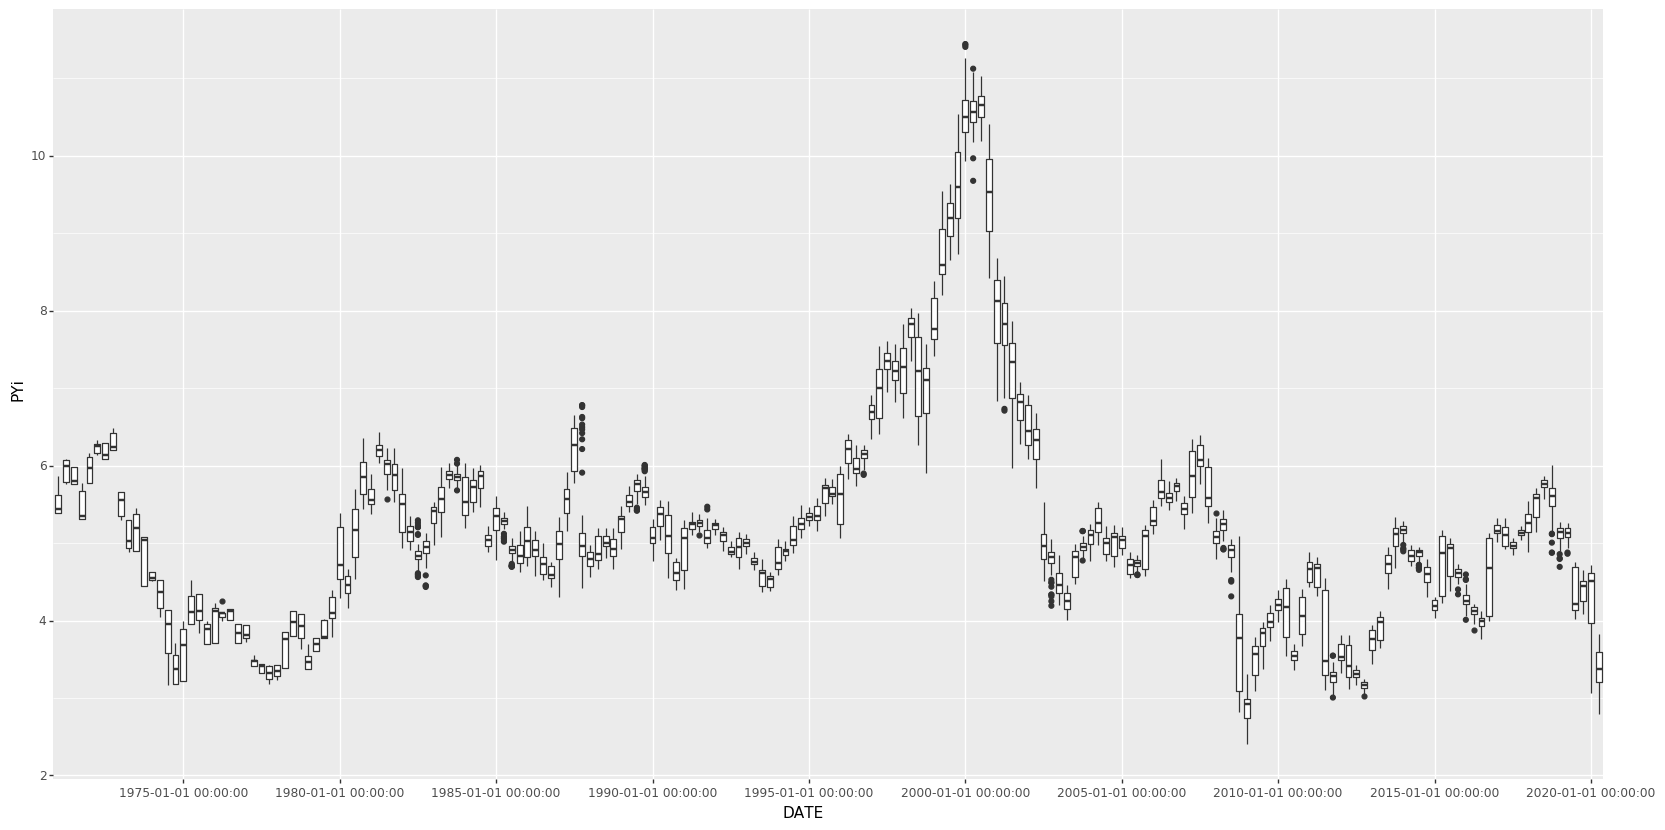

<ggplot: (8767659180084)>


In [27]:
print(ggplot(my_bv_df.loc[my_bv_df['YEAR'] > '1970-01-01'])
     + geom_boxplot(aes(x='factor(QTR)', y='PYi'))
#      + geom_rect(data=my_rec_df.loc[my_rec_df['start'] > '1970-01-01'], mapping=aes(xmin='start', xmax='end', ymin=-np.inf, ymax=np.inf), alpha=0.1)
     + scale_x_discrete(name='DATE', breaks=lambda arr: [x for x in arr if x.month == 1 and x.year % 5 == 0])
     + themes.theme_gray()
     + themes.theme(figure_size=(20,10)))

/Users/rbolkey/.pyenv/versions/anaconda3-2019.10/envs/python-finance/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/rbolkey/.pyenv/versions/anaconda3-2019.10/envs/python-finance/lib/python3.8/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_rect : Removed 3 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


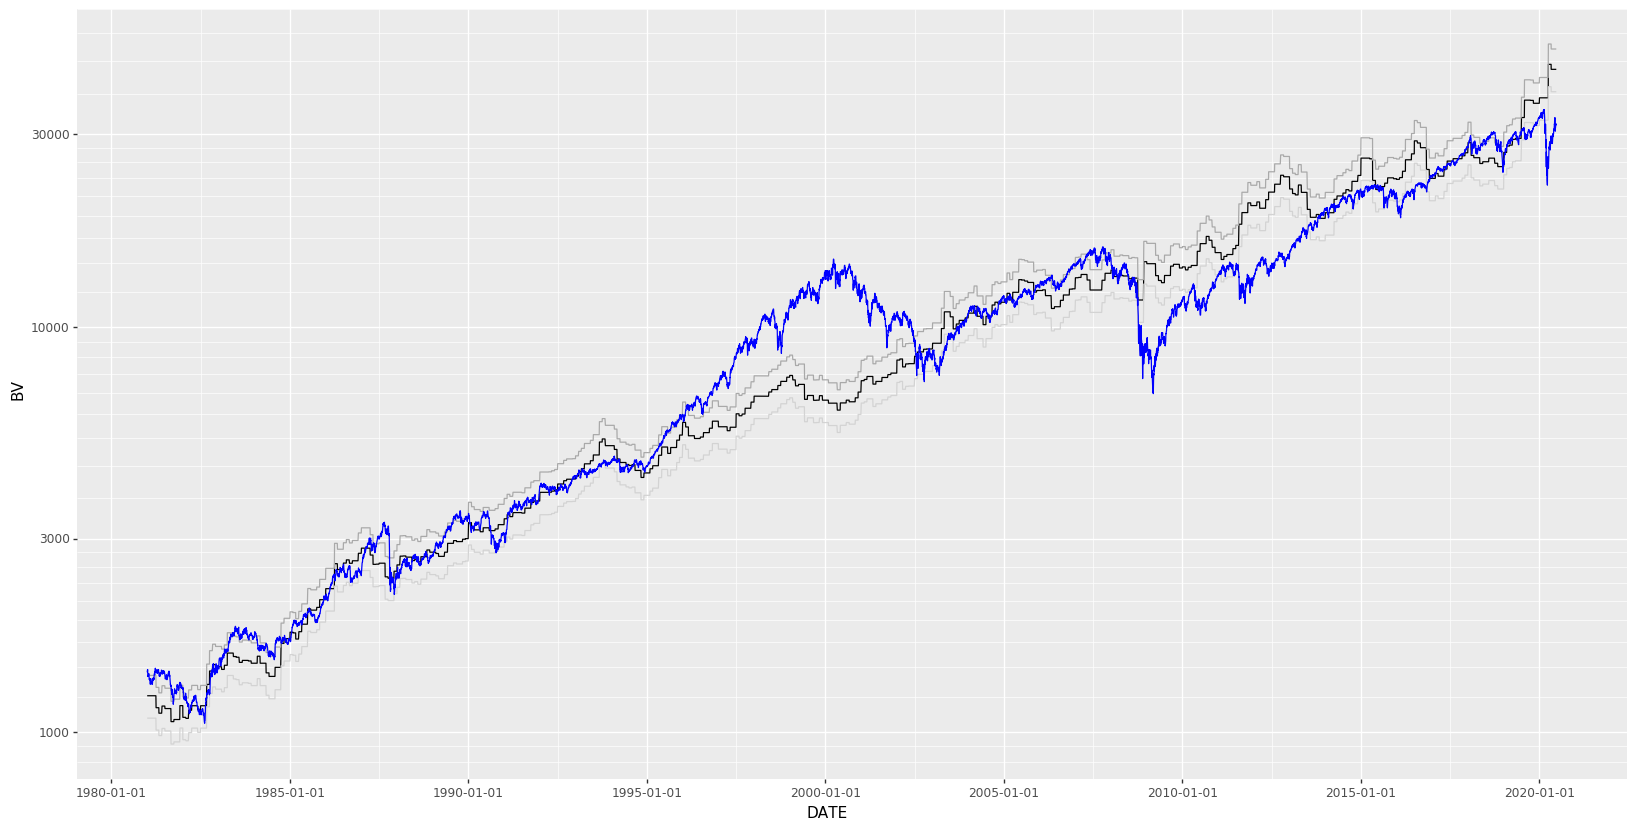

<ggplot: (8767662443072)>


In [44]:
print(ggplot(my_bv_df.loc[my_bv_df['YEAR'] > '1980-01-01'])
     + geom_line(aes(x='DATE', y='BV'))
     + geom_line(aes(x='DATE', y='BV25'), color='lightgrey')
     + geom_line(aes(x='DATE', y='BV75'), color='darkgrey')
     + geom_line(aes(x='DATE', y='WILL5000PRFC'), color='blue')
     + geom_rect(data=my_rec_df.loc[my_rec_df['start'] > '2000-01-01'], mapping=aes(xmin='start', xmax='end', ymin=-np.inf, ymax=np.inf), alpha=0.1)
     + scale_y_log10()
     + themes.theme_gray()
     + themes.theme(figure_size=(20,10)))